# DAT210x - Programming with Python for DS

## Module5- Lab7

In [2]:
import random, math
import pandas as pd
import numpy as np
import scipy.io

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

plt.style.use('ggplot') # Look Pretty


# Leave this alone until indicated:
Test_PCA = False

### A Convenience Function

This method is for your visualization convenience only. You aren't expected to know how to put this together yourself, although you should be able to follow the code by now:

In [3]:
def plotDecisionBoundary(model, X, y):
    print("Plotting...")

    fig = plt.figure()
    ax = fig.add_subplot(111)

    padding = 0.1
    resolution = 0.1

    #(2 for benign, 4 for malignant)
    colors = {2:'royalblue', 4:'lightsalmon'} 


    # Calculate the boundaris
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= x_range * padding
    y_min -= y_range * padding
    x_max += x_range * padding
    y_max += y_range * padding

    # Create a 2D Grid Matrix. The values stored in the matrix
    # are the predictions of the class at at said location
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # What class does the classifier say?
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour map
    plt.contourf(xx, yy, Z, cmap=plt.cm.seismic)
    plt.axis('tight')

    # Plot your testing points as well...
    for label in np.unique(y):
        indices = np.where(y == label)
        plt.scatter(X[indices, 0], X[indices, 1], c=colors[label], alpha=0.8)

    p = model.get_params()
    plt.title('K = ' + str(p['n_neighbors']))
    plt.show()

### The Assignment

Load in the dataset, identify nans, and set proper headers. Be sure to verify the rows line up by looking at the file in a text editor.

In [4]:
columns = ['sample', 'thickness', 'size', 'shape', 'adhesion', 'epithelial', 'nuclei', 'chromatin', 'nucleoli', 'mitoses', 'status']
df = pd.read_table('Datasets/breast-cancer-wisconsin.data', sep=',', names=columns)
df = df.drop('sample', axis=1)
df.replace('?',np.nan, inplace=True)
df = df.dropna(axis=0)
df.head()

,thickness,size,shape,adhesion,epithelial,nuclei,chromatin,nucleoli,mitoses,status
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


Copy out the status column into a slice, then drop it from the main dataframe. Always verify you properly executed the drop by double checking (printing out the resulting operating)! Many people forget to set the right axis here.

If you goofed up on loading the dataset and notice you have a `sample` column, this would be a good place to drop that too if you haven't already.

In [5]:
status = df[['status']]
df = df.drop('status', axis = 1)

With the labels safely extracted from the dataset, replace any nan values with the mean feature / column value:

Do train_test_split. Use the same variable names as on the EdX platform in the reading material, but set the random_state=7 for reproducibility, and keep the test_size at 0.5 (50%).

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, status, test_size=0.5, random_state=7)

Experiment with the basic SKLearn preprocessing scalers. We know that the features consist of different units mixed in together, so it might be reasonable to assume feature scaling is necessary. Print out a description of the dataset, post transformation. Recall: when you do pre-processing, which portion of the dataset is your model trained upon? Also which portion(s) of your dataset actually get transformed?

In [7]:
from sklearn import preprocessing
# scaler = preprocessing.Normalizer()
# scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.RobustScaler()
scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Dimensionality Reduction

PCA and Isomap are your new best friends

In [8]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()


if Test_PCA:
    print('Computing 2D Principle Components')
    # TODO: Implement PCA here. Save your model into the variable 'model'.
    # You should reduce down to two dimensions.
    
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

else:
    print('Computing 2D Isomap Manifold')
    # TODO: Implement Isomap here. Save your model into the variable 'model'
    # Experiment with K values from 5-10.
    # You should reduce down to two dimensions.

    from sklearn.manifold import Isomap
    iso = Isomap(n_components=2, n_neighbors =5)
    iso.fit(X_train)
    X_train = iso.transform(X_train)
    X_test = iso.transform(X_test)

Computing 2D Isomap Manifold


Train your model against data_train, then transform both `data_train` and `data_test` using your model. You can save the results right back into the variables themselves.

In [9]:
model.fit(X_train,y_train.values.ravel())
model.score(X_test, y_test)

0.96491228070175439

Implement and train `KNeighborsClassifier` on your projected 2D training data here. You can name your variable `knmodel`. You can use any `K` value from 1 - 15, so play around with it and see what results you can come up. Your goal is to find a good balance where you aren't too specific (low-K), nor are you too general (high-K). You should also experiment with how changing the weights parameter affects the results.

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
parameters = {
                'n_neighbors': (3, 5, 8, 10, 15),
                'weights':('uniform', 'distance')
             }

reg = GridSearchCV(model, parameters, verbose=1, scoring='accuracy')

reg.fit(X_train, y_train.values.ravel())

print('Best score: %0.3f' % reg.best_score_)
print('Best parameters set:')
best_parameters = reg.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))
y_predictions = reg.predict(X_test)
print('r2 on test set:', accuracy_score(y_test, y_predictions))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.956
Best parameters set:
	n_neighbors: 15
	weights: 'uniform'
r2 on test set: 0.979532163743


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


Be sure to always keep the domain of the problem in mind! It's WAY more important to errantly classify a benign tumor as malignant, and have it removed, than to incorrectly leave a malignant tumor, believing it to be benign, and then having the patient progress in cancer. Since the UDF weights don't give you any class information, the only way to introduce this data into SKLearn's KNN Classifier is by "baking" it into your data. For example, randomly reducing the ratio of benign samples compared to malignant samples from the training set.

Calculate and display the accuracy of the testing set:

Plotting...


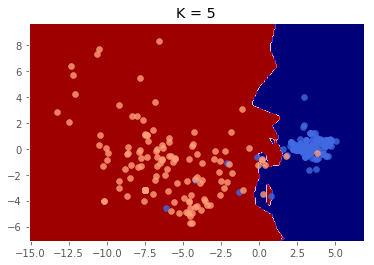

In [13]:
plotDecisionBoundary(model, X_test, y_test)